In [ ]:
!pip install exeteracovid

In [10]:
"""
This example shows the filtering functions of Exetera.
Presume we have the assessment dataset (contains the Covid symptoms), and want to examinate the number of 
healthy/unhealthy assessments reported each week.
We can use the date as a filter, to filter the assessment samples that falls in the specific range of dates. 
"""
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np
import h5py
import matplotlib.pyplot as plt

from exetera.core.session import Session
from exetera.core import dataframe

# Here we specify the start and end date to examinate
# start_date = # datetime(year, month, date), inclusive
# end_date = # datetime(year, month, date), exclusive
# filename = # file name for source dataset

# The date is then trunked by week (7 days)
dates = [end_date]
cur_date = end_date - timedelta(days=7)
while cur_date >= start_date:
    dates.append(cur_date)
    cur_date -= timedelta(days=7)
dates.reverse()

In [11]:
# Open Exetera session
with Session() as s:
    # Open the dataset
    src = s.open_dataset(filename, 'r', 'src')
    # Open the 'assessments' dataframe
    a_src = src['assessments']
    # Select the data from 'create_at' and 'health_status' column 
    asmt_created_at_ = a_src['created_at'].data[:]
    asmt_healthy_ = a_src['health_status'].data[:]
    # Create two numpy array to store the results
    partitions = len(dates)-1
    healthy_asmts_by_range = np.zeros(partitions, dtype=np.int32)
    unhealthy_asmts_by_range = np.zeros(partitions, dtype=np.int32)

    for d in range(partitions):
        print("period starting {}".format(dates[d]))
        start_timestamp = dates[d].timestamp()
        end_timestamp = dates[d+1].timestamp()
        # Create an identifier array of True/False values, to mark if the test is taken during the dates we want
        in_current_month = (start_timestamp <= asmt_created_at_) & (asmt_created_at_ < end_timestamp)
        
        # Use the identifier to filter data we want (by leave only the data indexed True values)
        tests_by_range = s.apply_filter(in_current_month, asmt_healthy_)
        
        # Counting results and store into the numpy array
        result_counts = np.unique(tests_by_range, return_counts=True)
        if len(result_counts[0]) == 0:
            healthy_asmts_by_range[d] = 0
            unhealthy_asmts_by_range[d] = 0
        else:
            result_counts = dict(zip(result_counts[0], result_counts[1]))
            healthy_asmts_by_range[d] = result_counts[0] + result_counts[1]
            unhealthy_asmts_by_range[d] = result_counts[2]


period starting 2020-04-02 00:00:00
{0: 94990, 1: 2874195, 2: 487948}
period starting 2020-04-09 00:00:00
(array([], dtype=int8), array([], dtype=int64))
period starting 2020-04-16 00:00:00
(array([], dtype=int8), array([], dtype=int64))
period starting 2020-04-23 00:00:00
(array([], dtype=int8), array([], dtype=int64))


<ipython-input-12-764a597a0fe8>:19: RuntimeWarning: invalid value encountered in true_divide
  pos_fraction = unhealthy_asmts_by_range / (unhealthy_asmts_by_range + healthy_asmts_by_range)


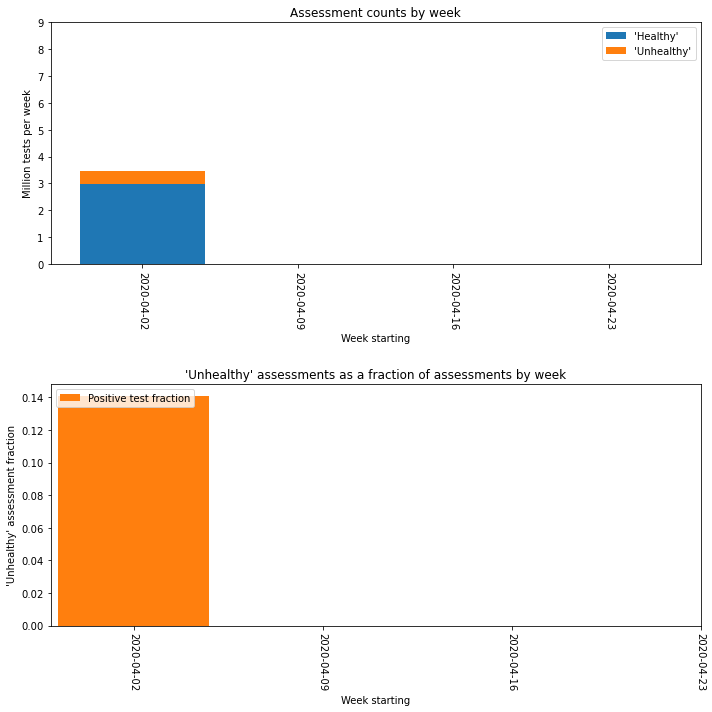

In [12]:
# Plot the data using matplotlib
width = 1
widths = [width * d for d in range(partitions)]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

negtests = ax[0].bar(widths, healthy_asmts_by_range)
postests = ax[0].bar(widths, unhealthy_asmts_by_range, bottom=healthy_asmts_by_range)

ax[0].set_title("Assessment counts by week")
ax[0].set_xticks(np.arange(partitions))
ax[0].set_xticklabels([datetime.strftime(d, '%Y-%m-%d') for d in dates[:-1]], rotation=270)
ax[0].set_yticks(np.arange(10) * 1000000)
ax[0].set_yticklabels(i for i in range(10))
ax[0].legend((negtests, postests), ("'Healthy'", "'Unhealthy'"))
ax[0].set_xlabel("Week starting")
ax[0].set_ylabel("Million tests per week")

pos_fraction = unhealthy_asmts_by_range / (unhealthy_asmts_by_range + healthy_asmts_by_range)
pfbar = ax[1].bar(widths, pos_fraction, color="#ff7f0e")

ax[1].set_title("'Unhealthy' assessments as a fraction of assessments by week")
ax[1].set_xticks(np.arange(partitions))
ax[1].set_xticklabels([datetime.strftime(d, '%Y-%m-%d') for d in dates[:-1]], rotation=270)
ax[1].legend((pfbar,), ("Positive test fraction",))
ax[1].set_xlabel("Week starting")
ax[1].set_ylabel("'Unhealthy' assessment fraction")

fig.tight_layout(h_pad=2.5)
plt.show()